In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import math
import numpy as np
from scipy import stats
from scipy.stats import norm
import pandas as pd

import seaborn as sns

from scipy.interpolate import interp1d
import pandas as pd 
from scipy import integrate
import numpy as np
import scipy.stats as ss
import time 

from scipy.stats import norm

In [2]:
#Black and Scholes
def BlackScholes(CallPutFlag,S,X,v,r,T):

    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))

    d2 = d1-v*np.sqrt(T)
    if CallPutFlag=="C":
        P = S*norm.cdf(d1) - X*np.exp(-r*T)*norm.cdf(d2)

    else:
        P = -S*norm.cdf(-d1) + X*np.exp(-r*T)*norm.cdf(-d2)
    return P

In [3]:
def ivol(K,IV,Kall):
    
    if Kall>=K[len(K)-1]:
        Kall=K[len(K)-1]
    if Kall<=K[0]:
        Kall=K[0]
    funy = interp1d(K,IV, kind='cubic', fill_value="extrapolate")
    y=funy(Kall)
  
    if (np.sum(y<0)>0):
        if Kall>=K[len(K)-1]:
            Kall=K[len(K)-1]
        if Kall<=K[0]:
            Kall=K[0]
        funy = interp1d(K,IV, kind='linear', fill_value="extrapolate")
        y=funy(Kall)
    return(y)

In [4]:
def RiskNeutralVolatilitySkewKurt_JVKR(Kvector, IVvector, S0, T, r):
    kmin=.1*S0;
    kmax=3.5*S0;
  
    def V1(K):
        V1=2*(1-np.log(K/S0))*BlackScholes("C",S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2)        
        return(V1)
    def V2(K):
        V2=2*(1+np.log(S0/K))*BlackScholes("P",S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2);        
        return(V2)
    
    def W1(K):
        W1=(6*np.log(K/S0)-3*np.power(np.log(K/S0),2))*BlackScholes("C",S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2);
        return(W1) 
  
    def W2(K):
        W2=(6*np.log(S0/K)+3*np.power(np.log(S0/K),2))*BlackScholes("P",S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2);
        return(W2) 
    
    def X1(K):
        X1=(((12*np.power(np.log(K/S0),2) - 4*np.power(np.log(K/S0),3)))*(BlackScholes("C",S0, K, ivol(Kvector,IVvector,K), r, T))/np.power(K,2));
        return(X1) 
  
    def X2(K):
        X2=(((12*np.power(np.log(S0/K),2) + 4*np.power(np.log(S0/K),3)))*(BlackScholes("P",S0, K, ivol(Kvector,IVvector,K), r, T))/np.power(K,2));
        return(X2) 
    V=integrate.quad(V1,S0,kmax)[0]+integrate.quad(V2,kmin,S0)[0]
    W=integrate.quad(W1,S0,kmax)[0]-integrate.quad(W2,kmin,S0)[0]
    X=integrate.quad(X1,S0,kmax)[0]+integrate.quad(X2,kmin,S0)[0]
    mu=np.exp(r*T)-1-np.exp(r*T)*V/2-np.exp(r*T)*W/6-np.exp(r*T)*X/24;
    #print(V,W,X,mu)
  
    vol=np.sqrt(1/T * V);
    skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2);
    kurt=( np.exp(r*T)*X - 4*mu*np.exp(r*T)*W + 6*np.exp(r*T)*np.power(mu,2)*V - 3*np.power(mu,4)) / np.power(np.exp(r*T)*V - np.power(mu,2),2);
  
    return([vol,skew,kurt]);

In [5]:
start_date = '2016-01-01'
end = '2016-04-30'


vix = data.DataReader("^VIX", 'yahoo', start_date, end)
vix['date'] = vix.index

In [6]:
opts = pd.read_csv('./SPX_2016_options.csv')
opts.columns = [s.strip(' ') for s in opts.columns]

drop_list = ['not important', 'not important.1', 'not important.2', 'not important.3', 'not important.4']
opts = opts.drop(labels=drop_list,axis=1)

In [7]:
opts['price'] = (opts['bid price']+opts['ask price'])/2

In [8]:
opts_big = opts[opts.price > 0.05]

In [9]:
calls = opts_big['call indicator']==1
puts = opts_big['call indicator']==-1

s_lower = opts_big['Current index level'] < opts_big['strike']
s_higher = opts_big['Current index level'] > opts_big['strike']


out_of_money = pd.concat([opts_big[puts & s_higher], opts_big[calls & s_lower]])

In [11]:
dates = []
maturities = []
volotils = []

N = len(out_of_money.groupby(['date','maturity']))
for i,g in enumerate(out_of_money.groupby(['date','maturity'])):
    try:
        print(i, 'out of', N)
        date,maturity = g[0]
        data = g[1]
        mean_vol = data['Black Scholes implied volatility'].mean()
        data.fillna(value=mean_vol)

        Kvector = list(data['strike'])
        IVvector = list(data['Black Scholes implied volatility'])
        S0 = data['Current index level'].max()
        r = data['interest rate'].max()
        T = maturity
        res = RiskNeutralVolatilitySkewKurt_JVKR(Kvector, IVvector, S0, T, r)

        dates.append(date)
        maturities.append(maturity)
        volotils.append(res[0])
    except:
        continue

0 out of 2329


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1 out of 2329


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


2 out of 2329


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in power


3 out of 2329
4 out of 2329
5 out of 2329
6 out of 2329
7 out of 2329
8 out of 2329
9 out of 2329
10 out of 2329
11 out of 2329
12 out of 2329
13 out of 2329
14 out of 2329
15 out of 2329
16 out of 2329
17 out of 2329
18 out of 2329
19 out of 2329
20 out of 2329
21 out of 2329
22 out of 2329
23 out of 2329
24 out of 2329
25 out of 2329
26 out of 2329
27 out of 2329
28 out of 2329
29 out of 2329
30 out of 2329
31 out of 2329
32 out of 2329
33 out of 2329
34 out of 2329
35 out of 2329
36 out of 2329
37 out of 2329
38 out of 2329
39 out of 2329
40 out of 2329
41 out of 2329
42 out of 2329
43 out of 2329
44 out of 2329
45 out of 2329
46 out of 2329
47 out of 2329
48 out of 2329
49 out of 2329
50 out of 2329
51 out of 2329
52 out of 2329
53 out of 2329
54 out of 2329
55 out of 2329
56 out of 2329
57 out of 2329
58 out of 2329
59 out of 2329
60 out of 2329
61 out of 2329
62 out of 2329
63 out of 2329
64 out of 2329
65 out of 2329
66 out of 2329
67 out of 2329
68 out of 2329
69 out of 2329
70

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in long_scalars


110 out of 2329
111 out of 2329
112 out of 2329
113 out of 2329
114 out of 2329
115 out of 2329
116 out of 2329
117 out of 2329
118 out of 2329
119 out of 2329
120 out of 2329
121 out of 2329
122 out of 2329
123 out of 2329
124 out of 2329
125 out of 2329
126 out of 2329
127 out of 2329
128 out of 2329
129 out of 2329
130 out of 2329
131 out of 2329
132 out of 2329
133 out of 2329
134 out of 2329
135 out of 2329
136 out of 2329
137 out of 2329
138 out of 2329
139 out of 2329
140 out of 2329
141 out of 2329
142 out of 2329
143 out of 2329
144 out of 2329
145 out of 2329
146 out of 2329
147 out of 2329
148 out of 2329
149 out of 2329
150 out of 2329
151 out of 2329
152 out of 2329
153 out of 2329
154 out of 2329
155 out of 2329
156 out of 2329
157 out of 2329
158 out of 2329
159 out of 2329
160 out of 2329
161 out of 2329
162 out of 2329
163 out of 2329
164 out of 2329
165 out of 2329
166 out of 2329
167 out of 2329
168 out of 2329
169 out of 2329
170 out of 2329
171 out of 2329
172 out 

623 out of 2329
624 out of 2329
625 out of 2329
626 out of 2329
627 out of 2329
628 out of 2329
629 out of 2329
630 out of 2329
631 out of 2329
632 out of 2329
633 out of 2329
634 out of 2329
635 out of 2329
636 out of 2329
637 out of 2329
638 out of 2329
639 out of 2329
640 out of 2329
641 out of 2329
642 out of 2329
643 out of 2329
644 out of 2329
645 out of 2329
646 out of 2329
647 out of 2329
648 out of 2329
649 out of 2329
650 out of 2329
651 out of 2329
652 out of 2329
653 out of 2329
654 out of 2329
655 out of 2329
656 out of 2329
657 out of 2329
658 out of 2329
659 out of 2329
660 out of 2329
661 out of 2329
662 out of 2329
663 out of 2329
664 out of 2329
665 out of 2329
666 out of 2329
667 out of 2329
668 out of 2329
669 out of 2329
670 out of 2329
671 out of 2329
672 out of 2329
673 out of 2329
674 out of 2329
675 out of 2329
676 out of 2329
677 out of 2329
678 out of 2329
679 out of 2329
680 out of 2329
681 out of 2329
682 out of 2329
683 out of 2329
684 out of 2329
685 out 

1128 out of 2329
1129 out of 2329
1130 out of 2329
1131 out of 2329
1132 out of 2329
1133 out of 2329
1134 out of 2329
1135 out of 2329
1136 out of 2329
1137 out of 2329
1138 out of 2329
1139 out of 2329
1140 out of 2329
1141 out of 2329
1142 out of 2329
1143 out of 2329
1144 out of 2329
1145 out of 2329
1146 out of 2329
1147 out of 2329
1148 out of 2329
1149 out of 2329
1150 out of 2329
1151 out of 2329
1152 out of 2329
1153 out of 2329
1154 out of 2329
1155 out of 2329
1156 out of 2329
1157 out of 2329
1158 out of 2329
1159 out of 2329
1160 out of 2329
1161 out of 2329
1162 out of 2329
1163 out of 2329
1164 out of 2329
1165 out of 2329
1166 out of 2329
1167 out of 2329
1168 out of 2329
1169 out of 2329
1170 out of 2329
1171 out of 2329
1172 out of 2329
1173 out of 2329
1174 out of 2329
1175 out of 2329
1176 out of 2329
1177 out of 2329
1178 out of 2329
1179 out of 2329
1180 out of 2329
1181 out of 2329
1182 out of 2329
1183 out of 2329
1184 out of 2329
1185 out of 2329
1186 out of 23

1610 out of 2329
1611 out of 2329
1612 out of 2329
1613 out of 2329
1614 out of 2329
1615 out of 2329
1616 out of 2329
1617 out of 2329
1618 out of 2329
1619 out of 2329
1620 out of 2329
1621 out of 2329
1622 out of 2329
1623 out of 2329
1624 out of 2329
1625 out of 2329
1626 out of 2329
1627 out of 2329
1628 out of 2329
1629 out of 2329
1630 out of 2329
1631 out of 2329
1632 out of 2329
1633 out of 2329
1634 out of 2329
1635 out of 2329
1636 out of 2329
1637 out of 2329
1638 out of 2329
1639 out of 2329
1640 out of 2329
1641 out of 2329
1642 out of 2329
1643 out of 2329
1644 out of 2329
1645 out of 2329
1646 out of 2329
1647 out of 2329
1648 out of 2329
1649 out of 2329
1650 out of 2329
1651 out of 2329
1652 out of 2329
1653 out of 2329
1654 out of 2329
1655 out of 2329
1656 out of 2329
1657 out of 2329
1658 out of 2329
1659 out of 2329
1660 out of 2329
1661 out of 2329
1662 out of 2329
1663 out of 2329
1664 out of 2329
1665 out of 2329
1666 out of 2329
1667 out of 2329
1668 out of 23

2092 out of 2329
2093 out of 2329
2094 out of 2329
2095 out of 2329
2096 out of 2329
2097 out of 2329
2098 out of 2329
2099 out of 2329
2100 out of 2329
2101 out of 2329
2102 out of 2329
2103 out of 2329
2104 out of 2329
2105 out of 2329
2106 out of 2329
2107 out of 2329
2108 out of 2329
2109 out of 2329
2110 out of 2329
2111 out of 2329
2112 out of 2329
2113 out of 2329
2114 out of 2329
2115 out of 2329
2116 out of 2329
2117 out of 2329
2118 out of 2329
2119 out of 2329
2120 out of 2329
2121 out of 2329
2122 out of 2329
2123 out of 2329
2124 out of 2329
2125 out of 2329
2126 out of 2329
2127 out of 2329
2128 out of 2329
2129 out of 2329
2130 out of 2329
2131 out of 2329
2132 out of 2329
2133 out of 2329
2134 out of 2329
2135 out of 2329
2136 out of 2329
2137 out of 2329
2138 out of 2329
2139 out of 2329
2140 out of 2329
2141 out of 2329
2142 out of 2329
2143 out of 2329
2144 out of 2329
2145 out of 2329
2146 out of 2329
2147 out of 2329
2148 out of 2329
2149 out of 2329
2150 out of 23

In [12]:
volotils_df = pd.DataFrame()
volotils_df['date'] = dates
volotils_df['maturity'] = maturities
volotils_df['volotility'] = volotils

In [13]:
dates = []
predicted_vix = []

for g in volotils_df.groupby('date'):
    date = g[0]
    df = g[1]
    
    x = df['maturity']
    y = df['volotility']
    f = interp1d(x,y)
    
    vix_pred = f(30)
    
    dates.append(date)
    predicted_vix.append(float(vix_pred))

In [38]:
estimated_vix = pd.DataFrame()
estimated_vix['date'] = dates
estimated_vix['vix_estimate'] = predicted_vix
estimated_vix = estimated_vix.fillna(value=estimated_vix['vix_estimate'].mean())

In [39]:
corr = np.corrcoef(estimated_vix['vix_estimate'],vix['Adj Close'])[0][1]
print('Corelation between estimated Vix and real Vix for the explored period = ',corr)

Corelation between estimated Vix and real Vix for the explored period =  0.8347514807098666


Estimated Vix


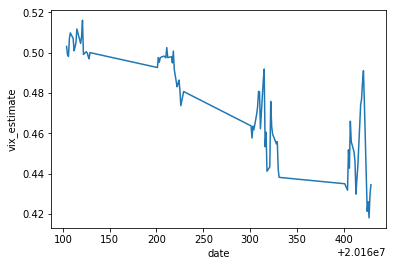

In [40]:
vix['date'] = list(estimated_vix['date'])
print('Estimated Vix')
sns.lineplot(x="date", y="vix_estimate", data=estimated_vix)

Original Vix


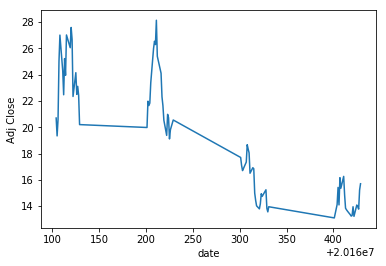

In [41]:
print('Original Vix')
sns.lineplot(x="date", y="Adj Close", data=vix)

## The graphs and the corelation coefficient show a strong correlation between the estimated values of the VIX and the actual VIX for this period of time